In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import skorch

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import *
#Transformers
from module import *

In [2]:
# Load training data set (small amount to test if it works first)

xtrain = r"data/training_sample_NoSparse.csv.gz"
ytrain = r"data/training_label_NoSparse.csv.gz"
xtest = r"data/testing_sample_NoSparse.csv.gz"
ytest = r"data/testing_label_NoSparse.csv.gz"


In [3]:
#check balance
samplesdf = pd.DataFrame()
for df in  pd.read_csv(ytrain,compression ="gzip",delimiter=',', chunksize = 10000, header=0):
    samplesdf = samplesdf.append(df)
y_train = samplesdf.to_numpy()

num0 = 0
num1 = 0
for x in y_train:
    if x == 0:
        num0 = num0 + 1
    else:
        num1 = num1 + 1
num0,num1 #checking if it is balanced

(15161, 14094)

In [4]:
df = pd.read_csv(xtrain,compression ="gzip",delimiter=',',nrows=1, header=0)
x_train = df.to_numpy()
print(x_train.shape)

(1, 3273)


In [5]:
class Dataset(Dataset):

    def __init__(self,samples,labels):

        self.data = pd.read_csv(samples,compression ="gzip",delimiter=',', header=0)
        self.label = pd.read_csv(labels,compression ="gzip",delimiter=',', header=0)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        rna = self.data.iloc[idx]
        seplb = self.label.iloc[idx]
        rna = np.array([rna])
        seplb = np.array([seplb])
        rna = rna.astype('double').reshape(-1,3273)
        i = 0
        d = np.zeros((len(seplb),2))
        for x in seplb:
            if x == 0:
                d[i] = [1,0]
            else:
                d[i] = [0,1]
        sample = {'rna': rna, 'label': d}

        return sample

In [6]:
train_dataset = Dataset(samples=xtrain,labels=ytrain)
test_dataset = Dataset(samples = xtest,labels = ytest)

In [7]:
# Hyper Parameters
EPOCH = 20             # train the training data n times, to save time, we just train 1 epoch
LR = 0.0001              # learning rate
batch_size = 32
wd = LR / EPOCH

In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
class SmallSetTransformer(nn.Module):
    def __init__(self,):
        super().__init__()
        self.enc = nn.Sequential(
            SAB(dim_in=3273, dim_out=256, num_heads=4),
            SAB(dim_in=256, dim_out=256, num_heads=4),
        )
        self.dec = nn.Sequential(
            PMA(dim=256, num_heads=4, num_seeds=1),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=256, out_features=2),
        )

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x.squeeze(-1)

In [10]:
trans = SmallSetTransformer()
optimizer = torch.optim.Adam(trans.parameters(), lr=LR)   
loss_func = nn.L1Loss()                      
if torch.cuda.is_available():
    loss_func = loss_func.cuda()
    trans = trans.cuda()
trans = trans.double()
print(trans)

SmallSetTransformer(
  (enc): Sequential(
    (0): SAB(
      (mab): MAB(
        (fc_q): Linear(in_features=3273, out_features=256, bias=True)
        (fc_k): Linear(in_features=3273, out_features=256, bias=True)
        (fc_v): Linear(in_features=3273, out_features=256, bias=True)
        (fc_o): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (1): SAB(
      (mab): MAB(
        (fc_q): Linear(in_features=256, out_features=256, bias=True)
        (fc_k): Linear(in_features=256, out_features=256, bias=True)
        (fc_v): Linear(in_features=256, out_features=256, bias=True)
        (fc_o): Linear(in_features=256, out_features=256, bias=True)
      )
    )
  )
  (dec): Sequential(
    (0): PMA(
      (mab): MAB(
        (fc_q): Linear(in_features=256, out_features=256, bias=True)
        (fc_k): Linear(in_features=256, out_features=256, bias=True)
        (fc_v): Linear(in_features=256, out_features=256, bias=True)
        (fc_o): Linear(in_features=256, out_fea

In [11]:
def test(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in train_loader:
            rna,labels = batch["rna"], batch["label"] 
            if torch.cuda.is_available():
                rna = rna.cuda()
                labels = labels.cuda()
            labels = labels.reshape(-1,2)
            outputs = model(rna)
            outputs = outputs.reshape(-1,2)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        TrainaccTest.append(correct/total)
           # print(total,correct)

        print('Train Accuracy of the model on the train rna: {} %'.format((correct / total) * 100))
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in test_loader:
            rna,labels = batch["rna"], batch["label"] 
            if torch.cuda.is_available():
                rna = rna.cuda()
                labels = labels.cuda()
            labels = labels.reshape(-1,2)
            outputs = model(rna)
            outputs = outputs.reshape(-1,2)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        TestaccTest.append(correct/total)
    #print(total,correct)

        print('Test Accuracy of the model on the test rna: {} %'.format((correct / total) * 100))



In [12]:
def train(model): 
    total_step = len(train_loader)
    num_epoch = EPOCH
    for epoch in range(num_epoch):
        model.train()
        for i, batch in enumerate(train_loader):
            # Run the forward pass
            rna,labels = batch["rna"], batch["label"] 
            if torch.cuda.is_available():
                rna = rna.cuda()
                labels = labels.cuda()
            outputs = model(rna)
            labels = labels.long()
            #print(outputs)
            outputs = outputs.reshape(-1,2)
            labels = labels.reshape(-1,2)
            loss = loss_func(outputs, labels)
            train_losses.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels.data, 1)
            correct = (predicted == labels).sum().item()
            train_acc.append(correct / total)
            if i % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                        .format(epoch + 1, num_epoch , i + 1, total_step, loss.item(),
                                (correct / total) * 100))
        test(model)

In [13]:
train_losses = []
train_acc = []
test_acc = []
TrainaccTest = []
TestaccTest = []
train(trans)

Epoch [1/20], Step [1/915], Loss: 0.4941, Accuracy: 59.38%
Epoch [1/20], Step [101/915], Loss: 0.4006, Accuracy: 68.75%
Epoch [1/20], Step [201/915], Loss: 0.3723, Accuracy: 71.88%
Epoch [1/20], Step [301/915], Loss: 0.4313, Accuracy: 62.50%
Epoch [1/20], Step [401/915], Loss: 0.4266, Accuracy: 71.88%
Epoch [1/20], Step [501/915], Loss: 0.3165, Accuracy: 87.50%
Epoch [1/20], Step [601/915], Loss: 0.3865, Accuracy: 71.88%
Epoch [1/20], Step [701/915], Loss: 0.3796, Accuracy: 65.62%
Epoch [1/20], Step [801/915], Loss: 0.2463, Accuracy: 90.62%
Epoch [1/20], Step [901/915], Loss: 0.3455, Accuracy: 75.00%
Train Accuracy of the model on the train rna: 79.56588617330371 %
Test Accuracy of the model on the test rna: 75.84078987966677 %
Epoch [2/20], Step [1/915], Loss: 0.2726, Accuracy: 87.50%
Epoch [2/20], Step [101/915], Loss: 0.3494, Accuracy: 81.25%
Epoch [2/20], Step [201/915], Loss: 0.3171, Accuracy: 78.12%
Epoch [2/20], Step [301/915], Loss: 0.3462, Accuracy: 75.00%
Epoch [2/20], Step [

Epoch [12/20], Step [101/915], Loss: 0.1173, Accuracy: 90.62%
Epoch [12/20], Step [201/915], Loss: 0.0781, Accuracy: 93.75%
Epoch [12/20], Step [301/915], Loss: 0.0350, Accuracy: 100.00%
Epoch [12/20], Step [401/915], Loss: 0.0948, Accuracy: 93.75%
Epoch [12/20], Step [501/915], Loss: 0.0548, Accuracy: 96.88%
Epoch [12/20], Step [601/915], Loss: 0.0982, Accuracy: 93.75%
Epoch [12/20], Step [701/915], Loss: 0.0644, Accuracy: 96.88%
Epoch [12/20], Step [801/915], Loss: 0.0214, Accuracy: 100.00%
Epoch [12/20], Step [901/915], Loss: 0.0628, Accuracy: 96.88%
Train Accuracy of the model on the train rna: 92.88668603657494 %
Test Accuracy of the model on the test rna: 83.83215057081148 %
Epoch [13/20], Step [1/915], Loss: 0.0626, Accuracy: 96.88%
Epoch [13/20], Step [101/915], Loss: 0.1290, Accuracy: 87.50%
Epoch [13/20], Step [201/915], Loss: 0.0856, Accuracy: 93.75%
Epoch [13/20], Step [301/915], Loss: 0.1398, Accuracy: 87.50%
Epoch [13/20], Step [401/915], Loss: 0.1112, Accuracy: 90.62%
Ep

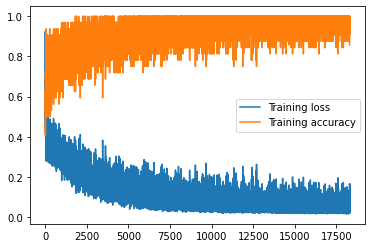

In [14]:
plt.plot(train_losses, label='Training loss')
plt.plot(train_acc, label='Training accuracy')
plt.legend()
plt.show()

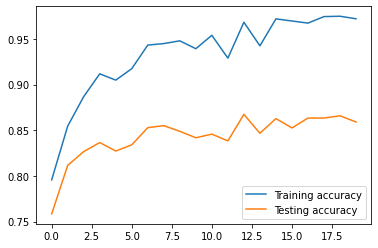

In [15]:
plt.plot(TrainaccTest, label='Training accuracy')
plt.plot(TestaccTest, label='Testing accuracy')
plt.legend()
plt.show()

torch.Size([3241, 3273])
torch.Size([3241, 1])
tensor([[ 1.0550, -0.0121],
        [ 0.9940,  0.0102],
        [ 0.9952,  0.0112],
        ...,
        [ 1.0079,  0.0022],
        [ 1.0550, -0.0112],
        [ 1.0433, -0.0083]], device='cuda:0', dtype=torch.float64)


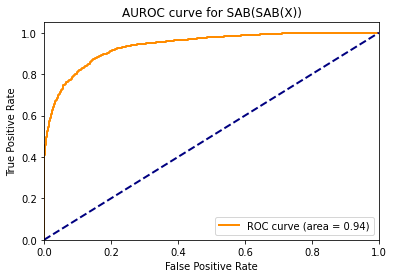

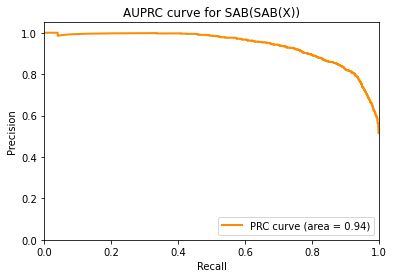

AUPRC = 0.94
f1_score = 0.86


In [16]:
samplesdf = pd.DataFrame()
samplesdf = pd.read_csv(xtest,compression ="gzip",delimiter=',',header=0)
x_test = samplesdf.to_numpy()

samplesdf = pd.DataFrame()
samplesdf = pd.read_csv(ytest,compression ="gzip",delimiter=',', header=0)
y_test = samplesdf.to_numpy()

x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
print(x_test.shape)
print(y_test.shape)
with torch.no_grad():
    trans.eval()
    if torch.cuda.is_available():
        x_test = x_test.cuda()
        y_test = y_test.cuda()
    x_test = x_test.reshape(-1,1,3273)
    outputs = trans(x_test)
    out = outputs.data.reshape(-1,2)
    print(out)
    predicted = np.zeros((len(out)))
    i = 0
    for x in out:
        predicted[i] = x[1]
        i = i + 1
    y_test = y_test.cpu()
    y_test = y_test.reshape(-1)
    fpr, tpr, _ = roc_curve(y_test,predicted)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr,tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUROC curve for SAB(SAB(X))')
    plt.legend(loc="lower right")
    plt.show()
    precision, recall, _ = precision_recall_curve(y_test,predicted)
    prc_auc = auc(recall,precision)
    plt.plot(recall,precision, color='darkorange',
             lw=lw, label='PRC curve (area = %0.2f)' % prc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('AUPRC curve for SAB(SAB(X))')
    plt.legend(loc="lower right")
    plt.show()
    print("AUPRC = %.02f"% prc_auc)
    ss = np.zeros((len(predicted)))
    i = 0
    for x in predicted:
        if x >= 0.5:
            ss[i] = 1
        else:
            ss[i] = 0
        i = i + 1
    f1s = f1_score(y_test,ss)
    print("f1_score = %.02f"% f1s)
    df = pd.DataFrame(y_test)
    df.to_csv(r"data/sabsablb2.csv.gz",index=False,sep=",",compression="gzip")
    df = pd.DataFrame(predicted)
    df.to_csv(r"data/sabsabpredict2.csv.gz",index=False,sep=",",compression="gzip")


In [17]:
len(TestaccTest)

20